In this experiment, a passive agent observes state and reward and learns a value function using TD learning. In 5 second trials, a tone sounds at some point and, after a delay of 1.5 seconds, a reward is received. Thus, this is a trace conditioning task. Both events -- the tone and reward -- are depicted as narrow Gaussian bumps (i.e., they are temporally extended, differentiable events rather instantaneous spikes). The `state' upon which the value function is learned is an LMU's memory state over the auditory signal. Note that the time window of this LMU, $\theta_{state}$, may differ from the time window of memories used to compute TD errors.  


We will test TD(0) and TD($\theta$). We expect that the agent will learn to anticipate reward following the tone, demonstrated by a value function that increases following the tone and decreases after the reward event begins.

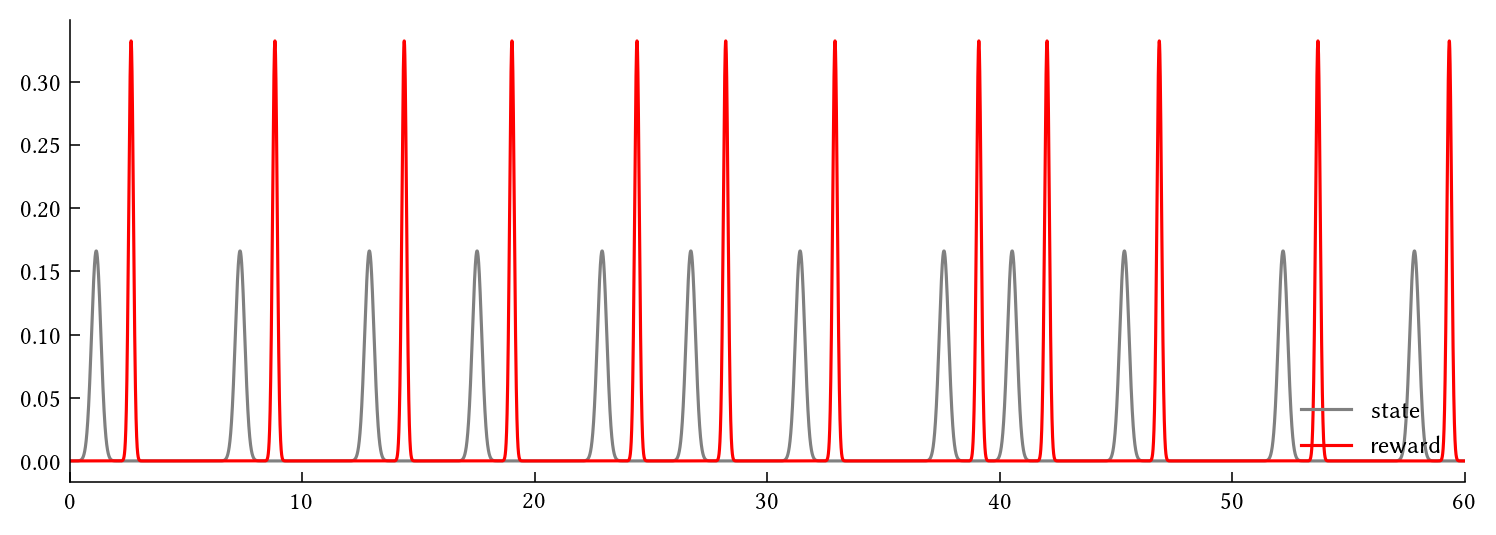

In [1]:
import sys,os
sys.path.insert(1, os.path.dirname(os.getcwd()))
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sspspace import HexagonalSSPSpace
import nengo
from online_rl_networks import ValueCritic, sparsity_to_x_intercept
from lmu_networks import LMUNetwork_v2, LMUProcess, LMUNetwork
from scipy.special import legendre
import utils.figure_utils as utils
# from brokenaxes import brokenaxes


T=60
dt = 0.001
timesteps = np.arange(0,T,dt)
d_trial = 5
d_delay = 1.5

theta_s = d_delay
n_trials = int(T/d_trial)

rew_o = 0.1
state_o = 0.2

state_centers = np.random.rand(n_trials)*(d_trial - state_o - rew_o*2 - d_delay) + state_o
state_centers = state_centers + d_trial*np.arange(n_trials)
def sim_fun(t):
    gausses = [(state_o*np.sqrt(2*np.pi))**(-1)*np.exp(-((t-c)/state_o)**2/2) for c in state_centers]
    return np.sum(np.array(gausses),axis=0)/len(state_centers)

sim_path = sim_fun(timesteps)

rew_centers = state_centers + d_delay
def reward_fun(t):
    gausses = [(rew_o*np.sqrt(2*np.pi))**(-1)*np.exp(-((t-c)/rew_o)**2/2) for c in rew_centers]
    return np.sum(np.array(gausses),axis=0)/len(rew_centers)

rewards = reward_fun(timesteps)
    
plt.figure(figsize=(9,3))

plt.plot(timesteps,sim_path, label='state',color='grey')
plt.plot(timesteps,rewards, label='reward', color='red')
plt.xlim([0,T])
plt.legend(loc='lower right')


In [2]:
n_neurons_state=400
n_neurons_value=400
discount = 0.95
theta = 0.5
n_neurons_lmu = 800
n_neurons_state = n_neurons_lmu
q_s = 12
q_n = 8
q_r = 8
q_v = 8


model = nengo.Network(seed=0)
with model:
    state = nengo.Node(sim_fun)
    reward = nengo.Node(reward_fun)


    state_lmu_ensemble = LMUNetwork_v2(n_neurons_lmu, theta=theta_s, q=q_s, size_in=1, tau=0.1, 
                                       radius=0.5,  intercepts=nengo.dists.Uniform(-0.1,0.3))
    nengo.Connection(state, state_lmu_ensemble.input, synapse=0.01)
    lmu = LMUProcess(theta=theta, q=q_n, size_in=n_neurons_lmu) 
    state_memory_lmu = nengo.Node(lmu)
    nengo.Connection(state_lmu_ensemble.lmu.ea_ensembles[0].neurons, state_memory_lmu, synapse=0.05)


    V_0 = ValueCritic(n_neurons_state,n_neurons_value, theta, 1, discount, q_n, q_r, q_v,'TD0',
                     T_test=0.8*T,learning_rate=2e-4, state_ensembles=[state_lmu_ensemble.lmu.ea_ensembles[0], state_memory_lmu])
    nengo.Connection(reward, V_0.reward_input, synapse=None)
    V_p = nengo.Probe(V_0.value, synapse=.05)



with nengo.Simulator(model,dt=dt) as sim:
    sim.run(T)
ts = sim.trange() 

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

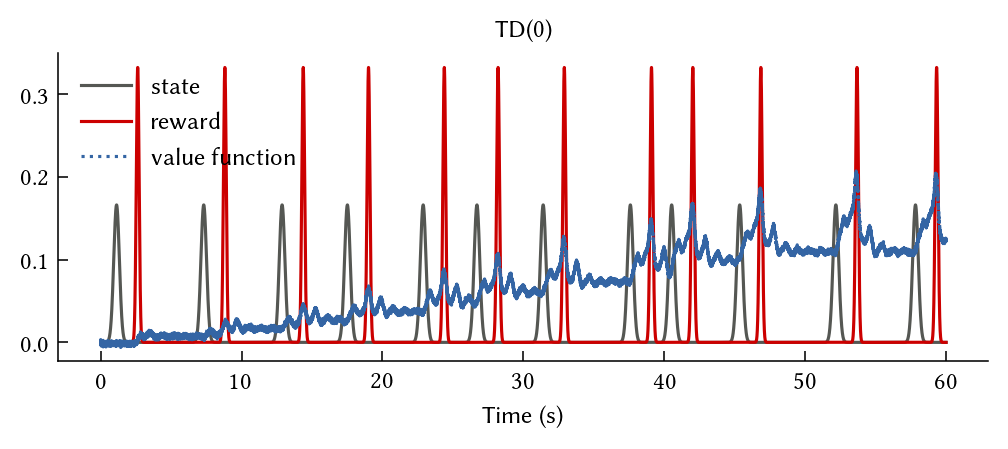

In [3]:
plt.figure(figsize=(6,2))
plt.plot(timesteps,sim_path, label='state',color=utils.grays[1])
plt.plot(timesteps,rewards, label='reward', color=utils.reds[1])
plt.plot(sim.trange(), sim.data[V_p],':', color=utils.blues[1], label='value function')

plt.legend()
plt.title('TD(0)')
plt.xlabel('Time (s)')
# plt.xlim([0,40])
v_0_output = sim.data[V_p]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

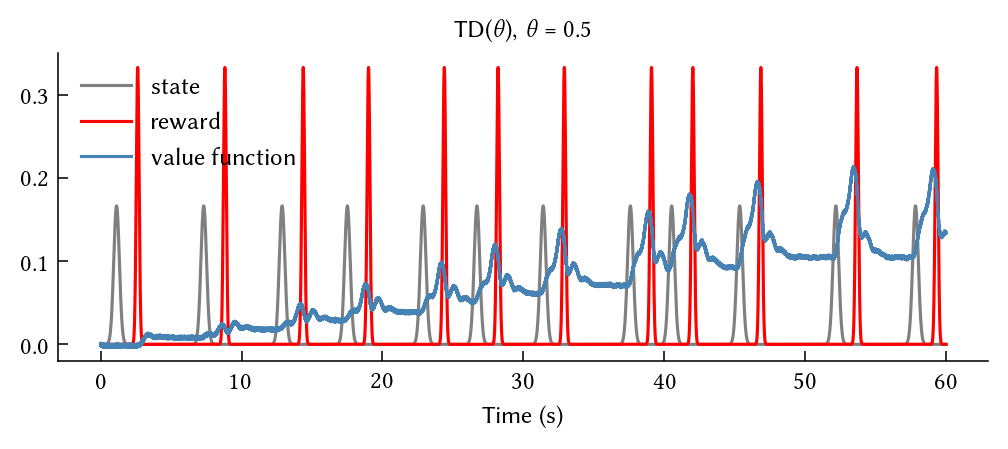

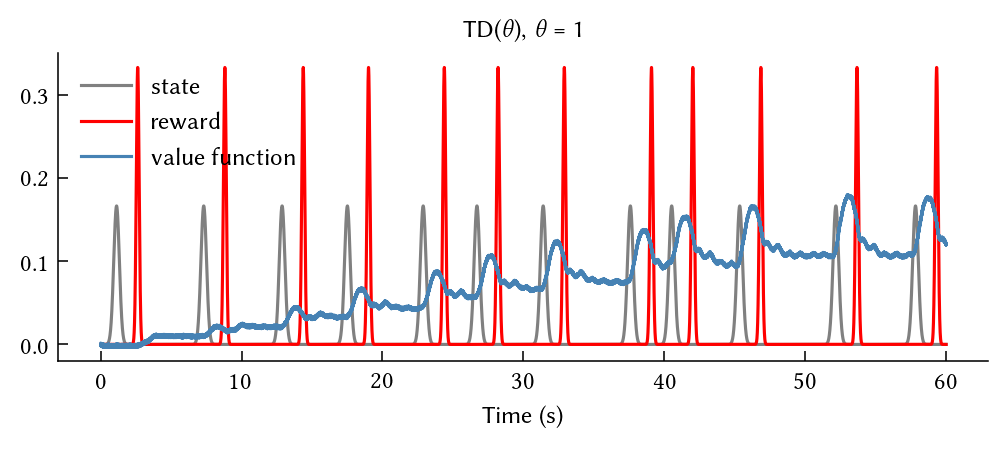

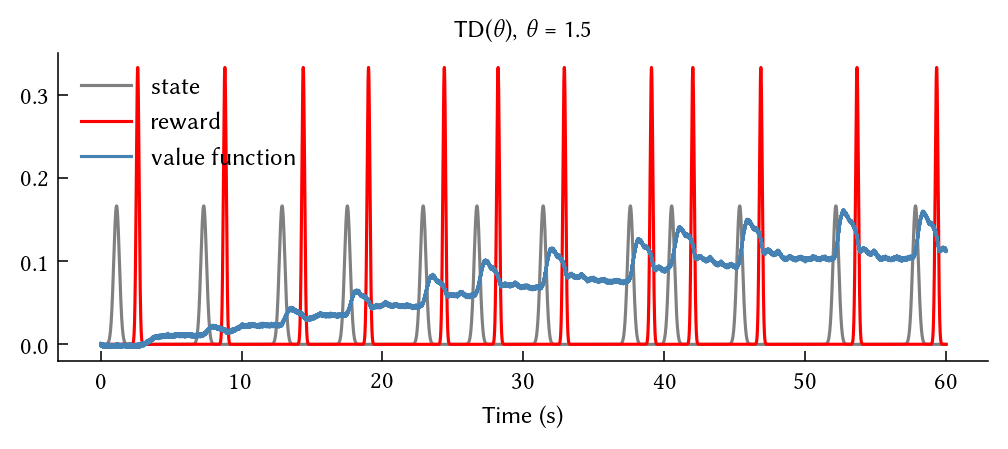

In [4]:
thetas = [0.5,1,1.5]

n_neurons_state=400
n_neurons_value=400
discount = 0.95
n_neurons_lmu = 800
n_neurons_state = n_neurons_lmu
q_s = 12
q_n = 8
q_r = 8
q_v = 8

v_theta_outputs = []
for i,theta in enumerate(thetas):
    
    model = nengo.Network(seed=0)
    with model:
        state = nengo.Node(sim_fun)
        reward = nengo.Node(reward_fun)
    
        state_lmu_ensemble = LMUNetwork_v2(n_neurons_lmu, theta=theta_s, q=q_s, size_in=1, tau=0.1, 
                                           radius=0.5,  intercepts=nengo.dists.Uniform(-0.1,0.3))
        nengo.Connection(state, state_lmu_ensemble.input, synapse=0.01)
        lmu = LMUProcess(theta=theta, q=q_n, size_in=n_neurons_lmu) 
        state_memory_lmu = nengo.Node(lmu)
        nengo.Connection(state_lmu_ensemble.lmu.ea_ensembles[0].neurons, state_memory_lmu, synapse=0.05)
        
    
        V_theta = ValueCritic(n_neurons_state,n_neurons_value, theta, 1, discount, q_n, q_r, q_v,'TDtheta',
                         T_test=0.8*T,learning_rate=2e-4, state_ensembles=[state_lmu_ensemble.lmu.ea_ensembles[0], state_memory_lmu])
        nengo.Connection(reward, V_theta.reward_input, synapse=None)
    
    
        
        V_p = nengo.Probe(V_theta.value, synapse=.1)
    
    
    with nengo.Simulator(model,dt=dt) as sim:
        sim.run(T)
    ts = sim.trange() 

    plt.figure(figsize=(6,2))
    plt.plot(timesteps,sim_path, label='state',color='grey')
    plt.plot(timesteps,rewards, label='reward', color='red')
    plt.plot(timesteps, sim.data[V_p], color='steelblue', label='value function')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.title('TD($\\theta$), $\\theta$ = ' + str(theta))
    v_theta_outputs.append(sim.data[V_p])
    
    
    

Text(0, 0.5, 'Value')

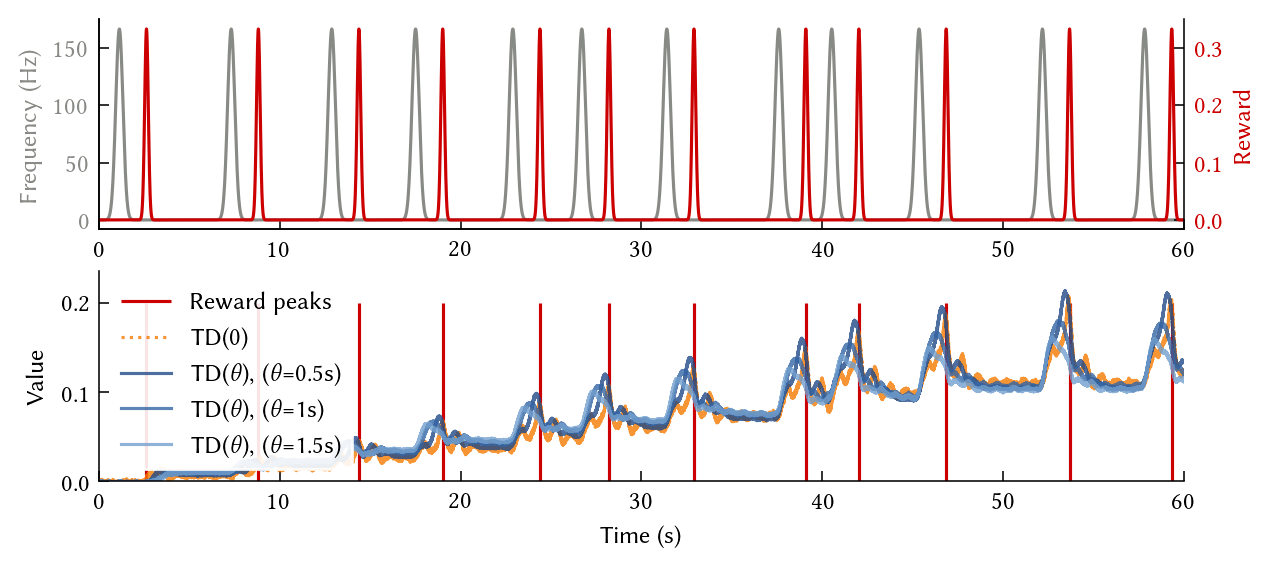

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(7,3))

ax1 = axs[0]
color = utils.grays[2]

ax1.set_ylabel('Frequency (Hz)', color=color)
ax1.plot(timesteps, sim_path*1000, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([0,T])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = utils.reds[1]
ax2.set_ylabel('Reward', color=color)  # we already handled the x-label with ax1
ax2.plot(timesteps, rewards, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.spines['right'].set_visible(True)
axs[1].vlines(rew_centers, 0,0.2, color=color,label='Reward peaks',alpha=1)

axs[1].plot(timesteps, v_0_output, ':', color=utils.oranges[1], label='TD(0)',alpha=0.8)
for i,theta in enumerate(thetas):
    axs[1].plot(sim.trange(), v_theta_outputs[i], '-', color=utils.blues[i], label='TD($\\theta$), ($\\theta$=' + str(theta) + 's)',alpha=0.8)
axs[1].legend(frameon=True,edgecolor='white',framealpha=0.9)
axs[1].set_xlim([0,T])
axs[1].set_ylim([0,np.max(np.array(v_theta_outputs))*1.1])

axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Value')